In [1]:
import logging; logging.basicConfig(level=logging.INFO)
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import logictensornetworks as ltn
import pandas as pd

# Data

Crabs dataset from: http://www.stats.ox.ac.uk/pub/PRNN/

The crabs data frame has 200 rows and 8 columns, describing 5 morphological measurements on 50 crabs each of two colour forms and both sexes, of the species Leptograpsus variegatus collected at Fremantle, W. Australia.

- Multi-class: Male, Female, Blue, Orange.
- Multi-label: Only Male-Female and Blue-Orange are mutually exclusive.


In [2]:
df = pd.read_csv("crabs.dat",sep=" ", skipinitialspace=True)
df = df.sample(frac=1) #shuffle
print(df.head(5))

    sp sex  index    FL    RW    CL    CW    BD
171  O   F     22  17.5  14.4  34.5  39.0  16.0
149  O   M     50  23.1  15.7  47.6  52.8  21.6
169  O   F     20  17.1  14.5  33.1  37.2  14.6
139  O   M     40  19.4  14.4  39.8  44.3  17.9
102  O   M      3  10.7   8.6  20.7  22.7   9.2


We use 160 samples for training and 40 samples for testing.

In [3]:
features = df[['FL','RW','CL','CW','BD']]
labels_sex = df['sex']
labels_color = df['sp']

batch_size=64
ds_train = tf.data.Dataset.from_tensor_slices((features[:160],labels_sex[:160],labels_color[:160])).batch(batch_size)
ds_test = tf.data.Dataset.from_tensor_slices((features[160:],labels_sex[160:],labels_color[160:])).batch(batch_size)

# LTN

### Predicate

| index | class | 
| --- | --- |
| 0 | Male |
| 1 | Female |
| 2 | Blue |
| 3 | Orange |

Let's note that, since the classes are not mutually exclusive, the last layer of the model will be a `sigmoid` and not a `softmax`.

In [4]:
class MLP(tf.keras.Model):
    """Model that returns logits."""
    def __init__(self, n_classes, hidden_layer_sizes=(16,16,8)):
        super(MLP, self).__init__()
        self.denses = [tf.keras.layers.Dense(s, activation="elu") for s in hidden_layer_sizes]
        self.dense_class = tf.keras.layers.Dense(n_classes)
        
    def call(self, inputs):
        x = inputs
        for dense in self.denses:
            x = dense(x)
        return self.dense_class(x)

logits_model = MLP(4)
p = ltn.Predicate(ltn.utils.LogitsToPredicateModel(logits_model,single_label=False))

Constants to index the classes

In [5]:
class_male = ltn.constant(0)
class_female = ltn.constant(1)
class_blue = ltn.constant(2)
class_orange = ltn.constant(3)

### Axioms

```
forall x_blue: C(x_blue,blue)
forall x_orange: C(x_orange,orange)
forall x_male: C(x_male,male)
forall x_female: C(x_female,female)
forall x: ~(C(x,male) & C(x,female))
forall x: ~(C(x,blue) & C(x,orange))
```

In [6]:
Not = ltn.Wrapper_Connective(ltn.fuzzy_ops.Not_Std())
And = ltn.Wrapper_Connective(ltn.fuzzy_ops.And_Prod())
Or = ltn.Wrapper_Connective(ltn.fuzzy_ops.Or_ProbSum())
Implies = ltn.Wrapper_Connective(ltn.fuzzy_ops.Implies_Reichenbach())
Forall = ltn.Wrapper_Quantifier(ltn.fuzzy_ops.Aggreg_pMeanError(p=2),semantics="forall")

In [7]:
formula_aggregator = ltn.fuzzy_ops.Aggreg_pMeanError(p=2)

@tf.function
def axioms(features,labels_sex,labels_color):
    x = ltn.variable("x",features)
    x_blue = ltn.variable("x_blue",features[labels_color=="B"])
    x_orange = ltn.variable("x_orange",features[labels_color=="O"])
    x_male = ltn.variable("x_blue",features[labels_sex=="M"])
    x_female = ltn.variable("x_blue",features[labels_sex=="F"])
    axioms = [
        Forall(x_blue, p([x_blue,class_blue])),
        Forall(x_orange, p([x_orange,class_orange])),
        Forall(x_male, p([x_male,class_male])),
        Forall(x_female, p([x_female,class_female])),
        Forall(x,Not(And(p([x,class_blue]),p([x,class_orange])))),
        Forall(x,Not(And(p([x,class_male]),p([x,class_female]))))
    ]
    axioms = tf.stack(axioms)
    sat_level = formula_aggregator(axioms)
    return sat_level, axioms

Initialize all layers and the static graph.

In [8]:
for features, labels_sex, labels_color in ds_train:
    print("Initial sat level %.5f"%axioms(features,labels_sex,labels_color)[0])
    break

Initial sat level 0.42693


# Training

Define the metrics. While training, we measure:
 1. The level of satisfiability of the Knowledge Base of the training data.
 1. The level of satisfiability of the Knowledge Base of the test data.
 3. The training accuracy.
 4. The test accuracy.
 5. The level of satisfiability of a formula phi_1 we expect to have a high truth value. 
       forall x (p(x,blue)->~p(x,orange))
 6. The level of satisfiability of a formula phi_1 we expect to have a low truth value. 
       forall x (p(x,blue)->p(x,orange))
 7. The level of satisfiability of a formula phi_1 we expect to have a neither high neither low truth value. 
       forall x (p(x,blue)->p(x,male))


In [9]:
metrics_dict = {
    'train_sat_kb': tf.keras.metrics.Mean(name='train_sat_kb'),
    'test_sat_kb': tf.keras.metrics.Mean(name='test_sat_kb'),
    'train_accuracy': tf.keras.metrics.Mean(name="train_accuracy"),
    'test_accuracy': tf.keras.metrics.Mean(name="test_accuracy"),
    'test_sat_phi1': tf.keras.metrics.Mean(name='test_sat_phi1'),
    'test_sat_phi2': tf.keras.metrics.Mean(name='test_sat_phi2'),
    'test_sat_phi3': tf.keras.metrics.Mean(name='test_sat_phi3')
}

@tf.function()
def phi1(features):
    x = ltn.variable("x",features)
    return Forall(x, Implies(p([x,class_blue]),Not(p([x,class_orange]))),p=5)

@tf.function()
def phi2(features):
    x = ltn.variable("x",features)
    return Forall(x, Implies(p([x,class_blue]),p([x,class_orange])),p=5)

@tf.function()
def phi3(features):
    x = ltn.variable("x",features)
    return Forall(x, Implies(p([x,class_blue]),p([x,class_male])),p=5)

def multilabel_hamming_loss(y_true, y_pred, threshold=0.5,from_logits=False):
    if from_logits:
        y_pred = tf.math.sigmoid(y_pred)
    y_pred = y_pred > threshold
    y_true = tf.cast(y_true, tf.int32)
    y_pred = tf.cast(y_pred, tf.int32)
    nonzero = tf.cast(tf.math.count_nonzero(y_true-y_pred,axis=-1),tf.float32)
    return nonzero/y_true.get_shape()[-1]


In [10]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
@tf.function
def train_step(features, labels_sex, labels_color):
    # sat and update
    with tf.GradientTape() as tape:
        sat = axioms(features, labels_sex, labels_color)[0]
        loss = 1.-sat
    gradients = tape.gradient(loss, p.trainable_variables)
    optimizer.apply_gradients(zip(gradients, p.trainable_variables))
    metrics_dict['train_sat_kb'](sat)
    # accuracy
    predictions = logits_model(features)
    labels_male = (labels_sex == "M")
    labels_female = (labels_sex == "F")
    labels_blue = (labels_color == "B")
    labels_orange = (labels_color == "O")
    onehot = tf.stack([labels_male,labels_female,labels_blue,labels_orange],axis=-1)
    metrics_dict['train_accuracy'](1-multilabel_hamming_loss(onehot,predictions,from_logits=True))
    
@tf.function
def test_step(features, labels_sex, labels_color):
    # sat
    sat_kb = axioms(features, labels_sex, labels_color)[0]
    metrics_dict['test_sat_kb'](sat_kb)
    sat_phi1 = phi1(features)
    metrics_dict['test_sat_phi1'](sat_phi1)
    sat_phi2 = phi2(features)
    metrics_dict['test_sat_phi2'](sat_phi2)
    sat_phi3 = phi3(features)
    metrics_dict['test_sat_phi3'](sat_phi3)
    # accuracy
    predictions = logits_model(features)
    labels_male = (labels_sex == "M")
    labels_female = (labels_sex == "F")
    labels_blue = (labels_color == "B")
    labels_orange = (labels_color == "O")
    onehot = tf.stack([labels_male,labels_female,labels_blue,labels_orange],axis=-1)
    metrics_dict['test_accuracy'](1-multilabel_hamming_loss(onehot,predictions,from_logits=True))


In [11]:
import commons

EPOCHS = 200

commons.train(
    EPOCHS,
    metrics_dict,
    ds_train,
    ds_test,
    train_step,
    test_step,
    csv_path="crabs_results.csv",
    track_metrics=20
)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



Epoch 0, train_sat_kb: 0.4271, test_sat_kb: 0.4286, train_accuracy: 0.5031, test_accuracy: 0.4875, test_sat_phi1: 0.9629, test_sat_phi2: 0.0090, test_sat_phi3: 0.9907
Epoch 20, train_sat_kb: 0.6164, test_sat_kb: 0.6198, train_accuracy: 0.5156, test_accuracy: 0.5188, test_sat_phi1: 0.5442, test_sat_phi2: 0.6940, test_sat_phi3: 0.8457
Epoch 40, train_sat_kb: 0.6655, test_sat_kb: 0.6696, train_accuracy: 0.6438, test_accuracy: 0.6500, test_sat_phi1: 0.6433, test_sat_phi2: 0.5946, test_sat_phi3: 0.7717
Epoch 60, train_sat_kb: 0.7128, test_sat_kb: 0.7123, train_accuracy: 0.8219, test_accuracy: 0.7875, test_sat_phi1: 0.7067, test_sat_phi2: 0.4759, test_sat_phi3: 0.6103
Epoch 80, train_sat_kb: 0.7842, test_sat_kb: 0.7824, train_accuracy: 0.9375, test_accuracy: 0.9125, test_sat_phi1: 0.7752, test_sat_phi2: 0.2827, test_sat_phi3: 0.4770
Epoch 100, train_sat_kb: 0.8409, test_sat_kb: 0.8335, train_accuracy: 0.9688, test_accuracy: 0.9500, test_sat_phi1: 0.8399, test_sat_phi2: 0.2249, test_sat_phi3:

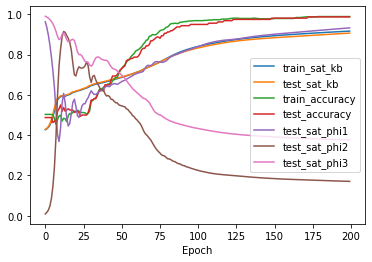

In [12]:
df_results = pd.read_csv("crabs_results.csv")
df_results.plot(x="Epoch")